# Chapter 3


`Original content created by Cam Davidson-Pilon`

`Ported to Python 3 and PyMC3 by Max Margenot (@clean_utensils) and Thomas Wiecki (@twiecki) at Quantopian (@quantopian)`

`Ported to Julia 1.6.1 and Turing by Abid`
____


## Opening the black box of MCMC

The previous two chapters hid the inner-mechanics of PyMC3, and more generally Markov Chain Monte Carlo (MCMC), from the reader. The reason for including this chapter is three-fold. The first is that any book on Bayesian inference must discuss MCMC. I cannot fight this. Blame the statisticians. Secondly, knowing the process of MCMC gives you insight into whether your algorithm has converged. (Converged to what? We will get to that) Thirdly, we'll understand *why* we are returned thousands of samples from the posterior as a solution, which at first thought can be odd. 

### The Bayesian landscape

When we setup a Bayesian inference problem with $N$ unknowns, we are implicitly creating an $N$ dimensional space for the prior distributions to exist in. Associated with the space is an additional dimension, which we can describe as the *surface*, or *curve*, that sits on top of the space, that reflects the *prior probability* of a particular point. The surface on the space is defined by our prior distributions. For example, if we have two unknowns $p_1$ and $p_2$, and priors for both are $\text{Uniform}(0,5)$, the space created is a square of length 5 and the surface is a flat plane that sits on top of the square (representing that every point is equally likely). 

In [1]:
using Plots

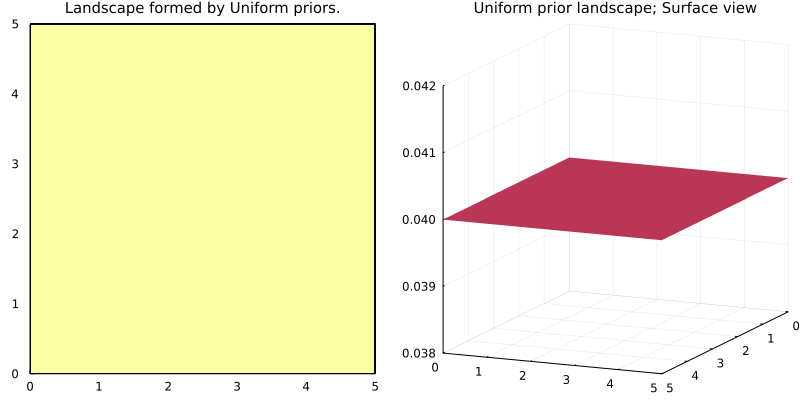

In [30]:
using Distributions,LinearAlgebra

x = LinRange(0,5,100)
y = x

uni_x = pdf(Uniform(0,5),x)
uni_y = pdf(Uniform(0,5),y)

M = transpose(uni_x).*uni_y

p1 = contour(x,y,M,title = "Landscape formed by Uniform priors.",fill = true,
               legend = nothing,titlefontsize  = 10,size = (800,400))
p2 =surface(x,y,M,zlim = (0.038,0.042),title = "Uniform prior landscape; Surface view",
               legend = nothing,titlefontsize  = 10,size = (800,400), yflip = true)

plot(p1,p2,layout = (1,2))

Alternatively, if the two priors are $\text{Exp}(3)$ and $\text{Exp}(10)$, then the space is all positive numbers on the 2-D plane, and the surface induced by the priors looks like a water fall that starts at the point (0,0) and flows over the positive numbers. 

The plots below visualize this. The more dark red the color, the more prior probability is assigned to that location. Conversely, areas with darker blue represent that our priors assign very low probability to that location. 

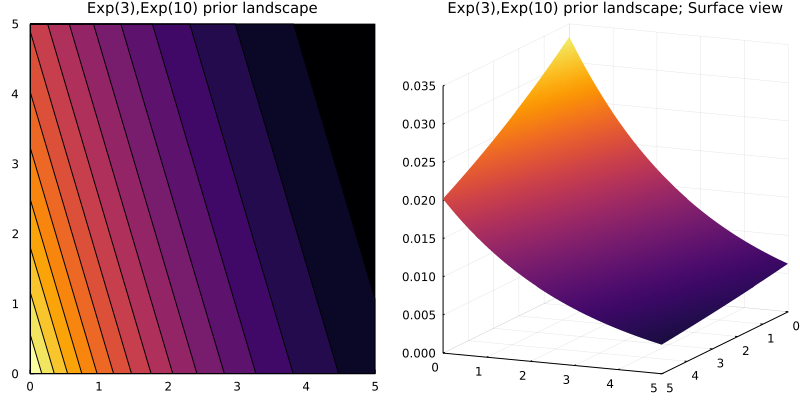

In [49]:
exp_x = pdf(Exponential(3),x)
exp_y = pdf(Exponential(10),y)

M = transpose(exp_x).*exp_y

p1 = contour(x,y,M,title = "Exp(3),Exp(10) prior landscape",fill = true,
              legend = nothing,titlefontsize  = 10,size = (800,400))
p2 =surface(x,y,M,title = "Exp(3),Exp(10) prior landscape; Surface view",
               yflip = true,legend = nothing,titlefontsize  = 10,zlim = (0,0.035),
                size = (800,400))

plot(p1,p2,layout = (1,2))

These are simple examples in 2D space, where our brains can understand surfaces well. In practice, spaces and surfaces generated by our priors can be much higher dimensional. 

If these surfaces describe our *prior distributions* on the unknowns, what happens to our space after we incorporate our observed data $X$? The data $X$ does not change the space, but it changes the surface of the space by *pulling and stretching the fabric of the prior surface* to reflect where the true parameters likely live. More data means more pulling and stretching, and our original shape becomes mangled or insignificant compared to the newly formed shape. Less data, and our original shape is more present.  Regardless, the resulting surface describes the *posterior distribution*. 

Again I must stress that it is, unfortunately, impossible to visualize this in large dimensions. For two dimensions, the data essentially *pushes up* the original surface to make *tall mountains*. The tendency of the observed data to *push up* the posterior probability in certain areas is checked by the prior probability distribution, so that less prior probability means more resistance. Thus in the double-exponential prior case above, a mountain (or multiple mountains) that might erupt near the (0,0) corner would be much higher than mountains that erupt closer to (5,5), since there is more resistance (low prior probability) near (5,5). The peak reflects the posterior probability of where the true parameters are likely to be found. Importantly, if the prior has assigned a probability of 0, then no posterior probability will be assigned there. 

Suppose the priors mentioned above represent different parameters $\lambda$ of two Poisson distributions. We observe a few data points and visualize the new landscape: 